In [1]:
# Load the World Energy Consumption dataset, inspect, and basic cleaning setup
# - Read CSV with provided encoding
# - Show head and basic shape/missingness overview
# - Keep dataframe in memory for later steps

import pandas as pd
import numpy as np
from tqdm import tqdm

# Read file
file_path = 'World Energy Consumption.csv'
df_energy = pd.read_csv(file_path, encoding='ascii')
df_energy.info()
df_energy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22012 entries, 0 to 22011
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.7+ MB


,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22007,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,NaN,NaN,NaN,NaN,25.910,...,0.218,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22008,Zimbabwe,2019,ZWE,15354606.0,NaN,NaN,NaN,NaN,NaN,24.748,...,0.364,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22009,Zimbabwe,2020,ZWE,15669663.0,NaN,NaN,NaN,NaN,NaN,22.336,...,0.395,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22010,Zimbabwe,2021,ZWE,15993525.0,NaN,NaN,NaN,NaN,NaN,23.760,...,0.498,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN


In [2]:
# Basic info for orientation
print(df_energy.shape)
print(df_energy.columns[:10])
print(df_energy.isna().mean().sort_values(ascending=False).head(15))

# Peek at the data
print(df_energy.head(10))

(22012, 129)
Index(['country', 'year', 'iso_code', 'population', 'gdp',
       'biofuel_cons_change_pct', 'biofuel_cons_change_twh',
       'biofuel_cons_per_capita', 'biofuel_consumption',
       'biofuel_elec_per_capita'],
      dtype='object')
biofuel_cons_change_pct             0.920634
solar_cons_change_pct               0.903507
biofuel_cons_per_capita             0.895421
wind_cons_change_pct                0.890378
nuclear_cons_change_pct             0.887925
biofuel_share_energy                0.878657
biofuel_cons_change_twh             0.877930
biofuel_consumption                 0.874296
other_renewables_cons_change_pct    0.838770
nuclear_energy_per_capita           0.828275
nuclear_share_energy                0.825731
electricity_share_energy            0.822869
solar_energy_per_capita             0.817827
solar_share_energy                  0.816691
wind_energy_per_capita              0.815328
dtype: float64
         country  year iso_code  population  gdp  biofuel_cons_

In [3]:
# Clean column types, create key features, and prepare multiple ML-ready datasets
# - Basic numeric coercion for selected columns
# - Handle missing values with simple strategies
# - Build three targets: next_year_energy, ghg_vs_gdp_pop
# - Show heads of the derived modeling tables

# Work on a copy
energy = df_energy.copy()

# Ensure year is int and sort
energy['year'] = energy['year'].astype(int)
energy = energy.sort_values(['country', 'year'])

# Coerce key numeric columns to numeric
numeric_cols = [
    'population','gdp','primary_energy_consumption','fossil_fuel_consumption',
    'renewables_consumption','low_carbon_consumption','greenhouse_gas_emissions',
    'electricity_generation','electricity_demand','coal_consumption','oil_consumption','gas_consumption',
    'carbon_intensity_elec','renewables_share_energy','fossil_share_energy','low_carbon_share_energy'
]
for c in numeric_cols:
    if c in energy.columns:
        energy[c] = pd.to_numeric(energy[c], errors='coerce')

# Simple forward fill within country, then backfill
energy = energy.groupby('country').apply(lambda g: g.ffill().bfill()).reset_index(drop=True)

# Create per-capita and intensity features
if 'primary_energy_consumption' in energy.columns:
    energy['energy_per_capita_calc'] = energy['primary_energy_consumption'] / energy['population']
if 'greenhouse_gas_emissions' in energy.columns:
    energy['ghg_per_capita'] = energy['greenhouse_gas_emissions'] / energy['population']
if 'gdp' in energy.columns:
    energy['energy_per_gdp_calc'] = energy['primary_energy_consumption'] / energy['gdp']

# Target 1: Predict next year's energy consumption (by country)
# Create a lead target per country
energy['next_year_energy'] = energy.groupby('country')['primary_energy_consumption'].shift(-1)
t1_cols = ['country','year','population','gdp','electricity_generation','coal_consumption','oil_consumption','gas_consumption','renewables_consumption','fossil_fuel_consumption','energy_per_capita_calc','energy_per_gdp_calc','next_year_energy']
T1 = energy[t1_cols].dropna()

# Target 2: Estimate impact of GDP/pop on GHG emissions (current year regression)
t2_cols = ['country','year','population','gdp','primary_energy_consumption','fossil_fuel_consumption','renewables_consumption','ghg_per_capita','greenhouse_gas_emissions']
T2 = energy[t2_cols].dropna()

print(T1.head())
print(T2.head())

C:\Users\Ritesh\AppData\Local\Temp\ipykernel_23808\883486169.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  energy = energy.groupby('country').apply(lambda g: g.ffill().bfill()).reset_index(drop=True)


     country  year  population           gdp  electricity_generation  \
588  Algeria  1900   4721802.0  1.019144e+10                  12.274   
589  Algeria  1901   4787149.0  1.019144e+10                  12.274   
590  Algeria  1902   4859600.0  1.019144e+10                  12.274   
591  Algeria  1903   4939332.0  1.019144e+10                  12.274   
592  Algeria  1904   5020372.0  1.019144e+10                  12.274   

     coal_consumption  oil_consumption  gas_consumption  \
588             0.814           15.405            7.431   
589             0.814           15.405            7.431   
590             0.814           15.405            7.431   
591             0.814           15.405            7.431   
592             0.814           15.405            7.431   

     renewables_consumption  fossil_fuel_consumption  energy_per_capita_calc  \
588                   1.183                    23.65                0.000005   
589                   1.183                    23.65

C:\Users\Ritesh\AppData\Local\Temp\ipykernel_23808\883486169.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  energy = energy.groupby('country').apply(lambda g: g.ffill().bfill()).reset_index(drop=True)


In [4]:
T1.head()

,country,year,population,gdp,electricity_generation,coal_consumption,oil_consumption,gas_consumption,renewables_consumption,fossil_fuel_consumption,energy_per_capita_calc,energy_per_gdp_calc,next_year_energy
588,Algeria,1900,4721802.0,1.019144e+10,12.274,0.814,15.405,7.431,1.183,23.65,0.000005,2.436653e-09,24.833
589,Algeria,1901,4787149.0,1.019144e+10,12.274,0.814,15.405,7.431,1.183,23.65,0.000005,2.436653e-09,24.833
590,Algeria,1902,4859600.0,1.019144e+10,12.274,0.814,15.405,7.431,1.183,23.65,0.000005,2.436653e-09,24.833
591,Algeria,1903,4939332.0,1.019144e+10,12.274,0.814,15.405,7.431,1.183,23.65,0.000005,2.436653e-09,24.833
592,Algeria,1904,5020372.0,1.019144e+10,12.274,0.814,15.405,7.431,1.183,23.65,0.000005,2.436653e-09,24.833


In [5]:
T2.tail()

,country,year,population,gdp,primary_energy_consumption,fossil_fuel_consumption,renewables_consumption,ghg_per_capita,greenhouse_gas_emissions
21627,World,2018,7.683790e+09,1.136302e+14,161402.734,135556.359,18990.977,0.000002,11955.92
21628,World,2019,7.764951e+09,1.136302e+14,163163.344,136105.719,19985.840,0.000002,11827.58
21629,World,2020,7.840953e+09,1.136302e+14,157357.797,129446.438,21134.498,0.000001,11480.07
21630,World,2021,7.909295e+09,1.136302e+14,165946.156,136585.125,22323.965,0.000002,12283.59
21631,World,2022,7.975105e+09,1.136302e+14,167787.672,137236.672,23848.668,0.000002,12447.70


In [6]:
df1=T1[T1['country']=='India']
df1

,country,year,population,gdp,electricity_generation,coal_consumption,oil_consumption,gas_consumption,renewables_consumption,fossil_fuel_consumption,energy_per_capita_calc,energy_per_gdp_calc,next_year_energy
9166,India,1900,2.807142e+08,2.716975e+11,186.386,413.407,146.995,2.373,56.676,562.775,0.000002,2.279929e-09,619.451
9167,India,1901,2.818341e+08,2.773278e+11,186.386,413.407,146.995,2.373,56.676,562.775,0.000002,2.233642e-09,619.451
9168,India,1902,2.831998e+08,3.006720e+11,186.386,413.407,146.995,2.373,56.676,562.775,0.000002,2.060222e-09,619.451
9169,India,1903,2.848130e+08,3.047644e+11,186.386,413.407,146.995,2.373,56.676,562.775,0.000002,2.032557e-09,619.451
9170,India,1904,2.864353e+08,3.060750e+11,186.386,413.407,146.995,2.373,56.676,562.775,0.000002,2.023854e-09,619.451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,India,2017,1.354196e+09,8.275647e+12,1471.160,4737.157,2571.897,535.999,653.606,7845.052,0.000006,1.038494e-09,9081.509
9284,India,2018,1.369003e+09,8.835758e+12,1578.980,4981.602,2688.057,579.963,732.744,8249.621,0.000007,1.027813e-09,9310.841
9285,India,2019,1.383112e+09,8.835758e+12,1621.910,4989.023,2775.680,592.498,839.401,8357.201,0.000007,1.053768e-09,8821.111
9286,India,2020,1.396387e+09,8.835758e+12,1562.710,4714.672,2520.253,603.601,870.152,7838.526,0.000006,9.983424e-10,9584.976


In [7]:
df2=T2[T2['country']=='India']
df2

,country,year,population,gdp,primary_energy_consumption,fossil_fuel_consumption,renewables_consumption,ghg_per_capita,greenhouse_gas_emissions
9166,India,1900,2.807142e+08,2.716975e+11,619.451,562.775,56.676,1.319029e-06,370.27
9167,India,1901,2.818341e+08,2.773278e+11,619.451,562.775,56.676,1.313787e-06,370.27
9168,India,1902,2.831998e+08,3.006720e+11,619.451,562.775,56.676,1.307452e-06,370.27
9169,India,1903,2.848130e+08,3.047644e+11,619.451,562.775,56.676,1.300046e-06,370.27
9170,India,1904,2.864353e+08,3.060750e+11,619.451,562.775,56.676,1.292683e-06,370.27
...,...,...,...,...,...,...,...,...,...
9284,India,2018,1.369003e+09,8.835758e+12,9081.509,8249.621,732.744,7.558857e-07,1034.81
9285,India,2019,1.383112e+09,8.835758e+12,9310.841,8357.201,839.401,7.482112e-07,1034.86
9286,India,2020,1.396387e+09,8.835758e+12,8821.111,7838.526,870.152,6.993978e-07,976.63
9287,India,2021,1.407564e+09,8.835758e+12,9584.976,8549.395,925.305,7.757872e-07,1091.97


In [8]:
# Train three models on the prepared tables T1, T2, and save models and example predictions
# - T1: GradientBoostingRegressor to predict next_year_energy
# - T2: ElasticNet to model greenhouse_gas_emissions from GDP/Pop/energy
# - Time-aware split within countries for T1; simple train/test for T2
# - Save models with joblib and sample predictions to CSVs; show heads and brief metrics

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import joblib

# Helper to compute metrics
def reg_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # Compute MSE first
    rmse = np.sqrt(mse)  # Then take square root for RMSE
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


# ------------------- T1: next_year_energy -------------------
T1_local = T1.copy()
feature_cols_t1 = [c for c in T1_local.columns if c not in ['country','year','next_year_energy']]
X1 = T1_local[feature_cols_t1]
y1 = T1_local['next_year_energy']
groups1 = T1_local['country']

# GroupKFold for countries (3 folds)
gkf = GroupKFold(n_splits=3)
preds1 = pd.Series(index=T1_local.index, dtype=float)

pipe1 = Pipeline([
    ('model', GradientBoostingRegressor(random_state=42))
])

for tr, va in gkf.split(X1, y1, groups1):
    pipe1.fit(X1.iloc[tr], y1.iloc[tr])
    preds1.iloc[va] = pipe1.predict(X1.iloc[va])

mae1, rmse1, r21 = reg_metrics(y1, preds1)

# Save model trained on all data
pipe1.fit(X1, y1)
joblib.dump(pipe1, 'model_t1_next_year_energy.joblib')

sample_pred1 = T1_local[['country','year']].copy()
sample_pred1['y_true'] = y1.values
sample_pred1['y_pred'] = preds1.values
sample_pred1.to_csv('predictions_t1_next_year_energy.csv', index=False)

# ------------------- T2: GHG vs GDP/Pop -------------------
T2_local = T2.copy()
feature_cols_t2 = ['population','gdp','primary_energy_consumption','fossil_fuel_consumption','renewables_consumption']
X2 = T2_local[feature_cols_t2]
y2 = T2_local['greenhouse_gas_emissions']

# Train/test split (stratify not applicable for regression)
X2_tr, X2_te, y2_tr, y2_te = train_test_split(X2, y2, test_size=0.2, random_state=42)

pipe2 = Pipeline([
    ('scale', StandardScaler()),
    ('model', ElasticNet(alpha=0.001, l1_ratio=0.2, random_state=42, max_iter=10000))
])

pipe2.fit(X2_tr, y2_tr)

pred2_tr = pipe2.predict(X2_tr)
pred2_te = pipe2.predict(X2_te)
mae2_tr, rmse2_tr, r22_tr = reg_metrics(y2_tr, pred2_tr)
mae2_te, rmse2_te, r22_te = reg_metrics(y2_te, pred2_te)

joblib.dump(pipe2, 'model_t2_ghg_elasticnet.joblib')

sample_pred2 = X2_te.copy()
sample_pred2['y_true'] = y2_te.values
sample_pred2['y_pred'] = pred2_te
sample_pred2.to_csv('predictions_t2_ghg.csv', index=False)

print(sample_pred1.head())
print(mae1)
print(rmse1)
print(r21)

print(sample_pred2.head())
print(mae2_te)
print(rmse2_te)
print(r22_te)

     country  year  y_true     y_pred
588  Algeria  1900  24.833  26.734089
589  Algeria  1901  24.833  26.734089
590  Algeria  1902  24.833  26.734089
591  Algeria  1903  24.833  26.734089
592  Algeria  1904  24.833  26.734089
655.3345975726587
6093.571012033312
0.6501431194231977
       population           gdp  primary_energy_consumption  \
17830   7042968.0  5.494079e+10                     354.229   
18326  24576871.0  9.354768e+10                     337.407   
16806  12525509.0  6.289416e+09                     278.721   
7265   40631855.0  2.830507e+11                    1309.656   
5079     766417.0  9.131655e+09                      17.845   

       fossil_fuel_consumption  renewables_consumption  y_true      y_pred  
17830                  354.119                   0.109  149.26   52.324820  
18326                  397.363                  58.214   94.03   85.501748  
16806                  275.749                   2.972   22.72   51.522880  
7265                  1168.484

In [9]:
# Target 1: Predict next year's energy consumption (by country)
# Create a lead target per country
energy['next_year_energy'] = energy.groupby('country')['primary_energy_consumption'].shift(-1)
t1_cols = ['country','year','population','gdp','electricity_generation','coal_consumption','oil_consumption','gas_consumption','renewables_consumption','fossil_fuel_consumption','energy_per_capita_calc','energy_per_gdp_calc','next_year_energy']
T1 = energy[t1_cols].dropna()


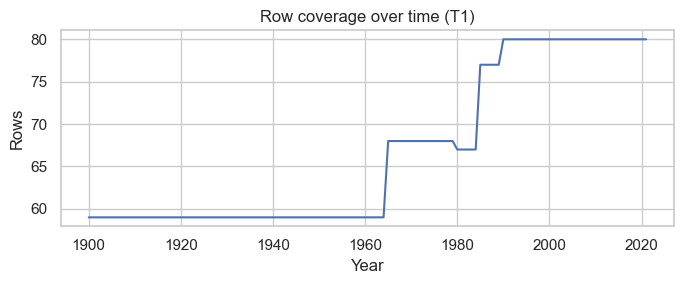

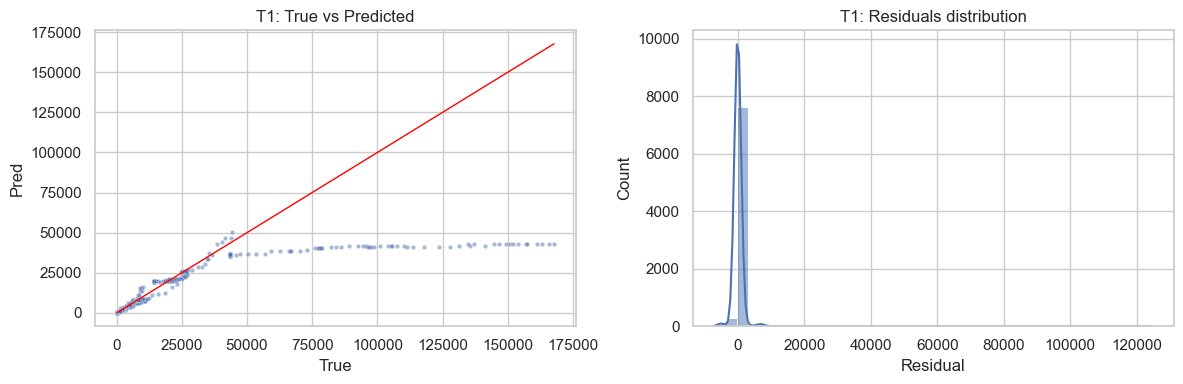

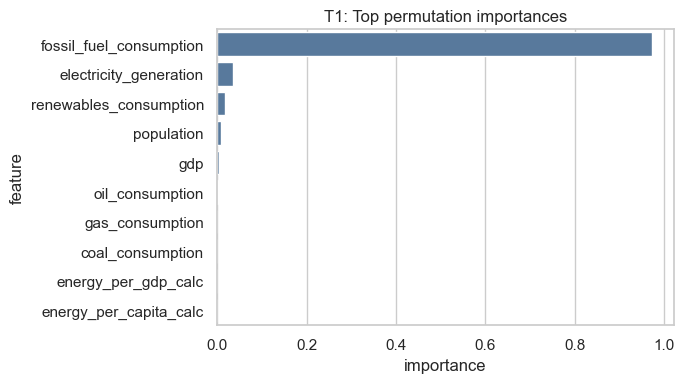

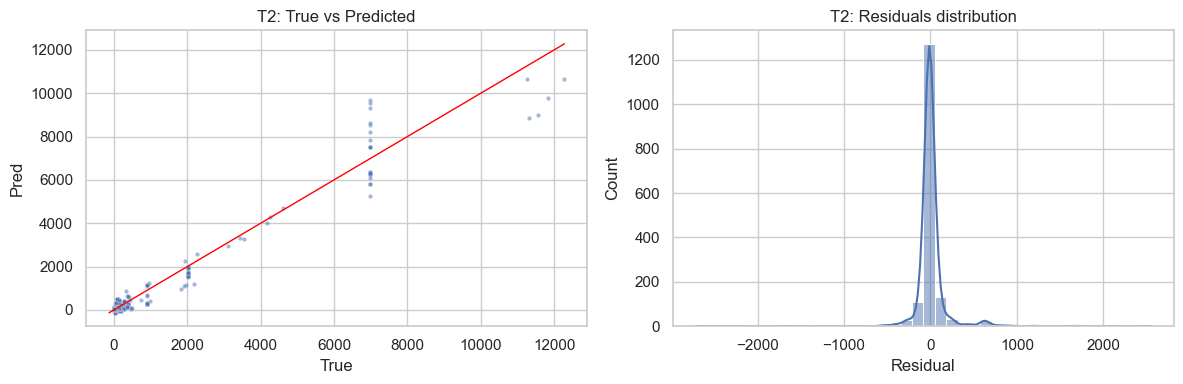

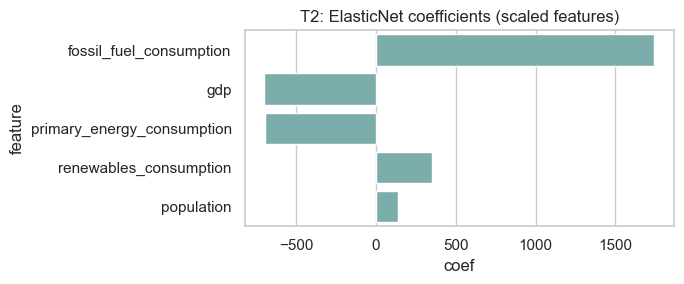

In [10]:
# This cell will create a compact set of visuals to summarize the project:
# - Data coverage over time
# - Target vs prediction scatter/residual views for T1 and T2
# - Feature importance for T1 (GBR) and coefficients for T2 (ElasticNet)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

sns.set(style='whitegrid')

# 1) Data coverage by year (count of rows per year)
if 'year' in T1.columns:
    plt.figure(figsize=(7,3))
    T1.groupby('year').size().plot(kind='line')
    plt.title('Row coverage over time (T1)')
    plt.xlabel('Year')
    plt.ylabel('Rows')
    plt.tight_layout()
    plt.show()

# 2) T1: Scatter y_true vs y_pred and residuals
try:
    pred_t1 = pd.read_csv('predictions_t1_next_year_energy.csv')
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.scatterplot(x=pred_t1['y_true'], y=pred_t1['y_pred'], s=10, alpha=0.5)
    plt.plot([pred_t1['y_true'].min(), pred_t1['y_true'].max()], [pred_t1['y_true'].min(), pred_t1['y_true'].max()], color='red', lw=1)
    plt.title('T1: True vs Predicted')
    plt.xlabel('True')
    plt.ylabel('Pred')

    plt.subplot(1,2,2)
    resid1 = pred_t1['y_true'] - pred_t1['y_pred']
    sns.histplot(resid1, bins=40, kde=True)
    plt.title('T1: Residuals distribution')
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(e)

# 3) T1: Feature importance via permutation on a subset for speed
try:
    import joblib
    model_t1 = joblib.load('model_t1_next_year_energy.joblib')
    feature_cols_t1 = [c for c in T1.columns if c not in ['country','year','next_year_energy']]
    X1_small = T1[feature_cols_t1].head(3000)
    y1_small = T1['next_year_energy'].head(3000)
    r = permutation_importance(model_t1, X1_small, y1_small, n_repeats=5, random_state=42)
    imp_df = pd.DataFrame({'feature': feature_cols_t1, 'importance': r.importances_mean}).sort_values('importance', ascending=False).head(15)
    plt.figure(figsize=(7,4))
    sns.barplot(data=imp_df, x='importance', y='feature', color='#4C78A8')
    plt.title('T1: Top permutation importances')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(e)

# 4) T2: True vs Pred and residuals
try:
    pred_t2 = pd.read_csv('predictions_t2_ghg.csv')
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.scatterplot(x=pred_t2['y_true'], y=pred_t2['y_pred'], s=10, alpha=0.5)
    vmin = min(pred_t2['y_true'].min(), pred_t2['y_pred'].min())
    vmax = max(pred_t2['y_true'].max(), pred_t2['y_pred'].max())
    plt.plot([vmin, vmax], [vmin, vmax], color='red', lw=1)
    plt.title('T2: True vs Predicted')
    plt.xlabel('True')
    plt.ylabel('Pred')

    plt.subplot(1,2,2)
    resid2 = pred_t2['y_true'] - pred_t2['y_pred']
    sns.histplot(resid2, bins=40, kde=True)
    plt.title('T2: Residuals distribution')
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(e)

# 5) T2: Coefficients from ElasticNet (after scaling)
try:
    import joblib
    pipe2 = joblib.load('model_t2_ghg_elasticnet.joblib')
    coef = pipe2.named_steps['model'].coef_
    feats = ['population','gdp','primary_energy_consumption','fossil_fuel_consumption','renewables_consumption']
    coef_df = pd.DataFrame({'feature': feats, 'coef': coef}).sort_values('coef', key=lambda x: abs(x), ascending=False)
    plt.figure(figsize=(7,3))
    sns.barplot(data=coef_df, x='coef', y='feature', color='#72B7B2')
    plt.title('T2: ElasticNet coefficients (scaled features)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(e)